<a href="https://colab.research.google.com/github/Charmaineem/ML/blob/main/Tweets_Claffication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweets Sentiment Analysis using Text Classification

Sentiment analysis via text classifaction using DistilBERT. It has 40% less parameters than Bert-base-uncased, runs 60% faster while preserving over 95% of BERT's performances.

###The Dataset

Emotions dataset with 6 basic emotions: sad, anger, fear, joy, love

In [1]:
!pip install transformers --quiet
!pip install datasets --quiet

In [2]:
from datasets import load_dataset

In [3]:
emotions = load_dataset('emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Visualisation of the Dataset

In [5]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [7]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
import matplotlib.pyplot as plt

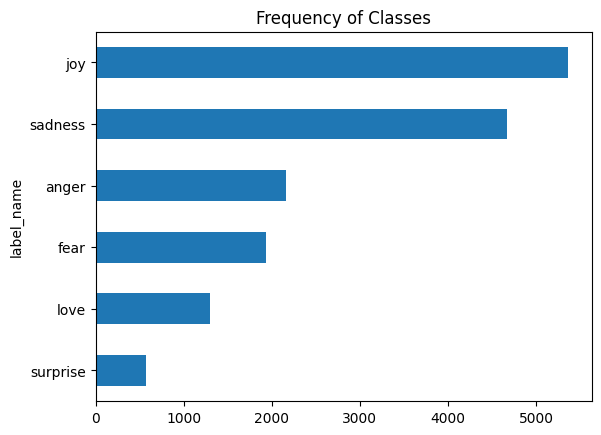

In [9]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

The dataset is not balanced. To deal with unbalanced data one can


*   randomly oversample the minority class
* randomly undersample the majority class
* gather more data

However in this project, I will work with the data as is!


#### Mazimum Context Size

Transformer models have a maximum input sequence length and for DistillBert it is 512 tokens. Anything above this needs to be cutoff leading to loss of information

In [10]:
df.columns

Index(['text', 'label', 'label_name'], dtype='object')

In [11]:
df['Words per tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,Words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


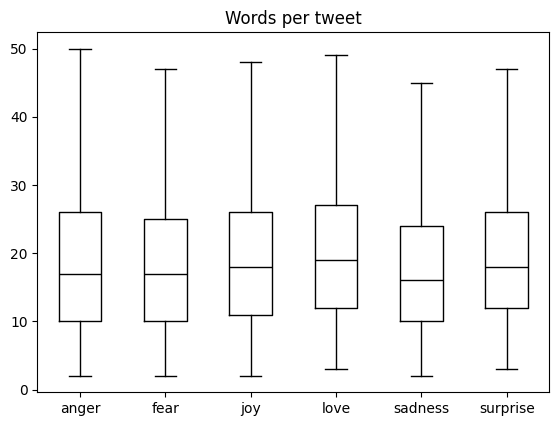

In [12]:
df.boxplot('Words per tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

Most tweets throughout the six emotions have length around 15

In [13]:
emotions.reset_format()

### Tokenization

Breaking down text into atomic units used in the model

In [14]:
from transformers import AutoTokenizer

In [15]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [17]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Training a Classifier

### Transformers as feature extractors

- Freeze the body weights during training
- Use the hidden states as feature the classifier

Quickly train a small model
Good for resource constrained devices
Low accuracy


In [19]:
!pip install torch --quiet

### Retrieving last hidden state of string

In [20]:
text = 'I love machine learning always'
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 7])


In [21]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 1045, 2293, 3698, 4083, 2467,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1]]))])

In [22]:
for k,v in inputs.items():
  print(k,v)

input_ids tensor([[ 101, 1045, 2293, 3698, 4083, 2467,  102]])
attention_mask tensor([[1, 1, 1, 1, 1, 1, 1]])


In [23]:
from transformers import AutoModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [24]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [25]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask" , "label"])

In [26]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

In [28]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

#### Visualizing the training set

In [29]:
!pip install umap-learn

In [31]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X' , 'Y'])
df_emb['label'] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.237502,6.512352,0
1,-3.140042,5.375010,0
2,5.583708,2.935667,3
3,-2.474736,3.211122,2
4,-3.515585,3.427241,3


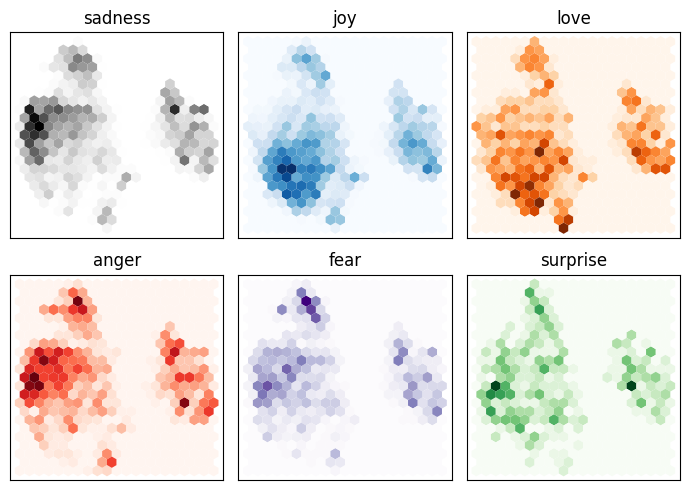

In [34]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels,cmaps)):
  df_emb_sub = df_emb.query(f'label == {i}')
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [36]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true,labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

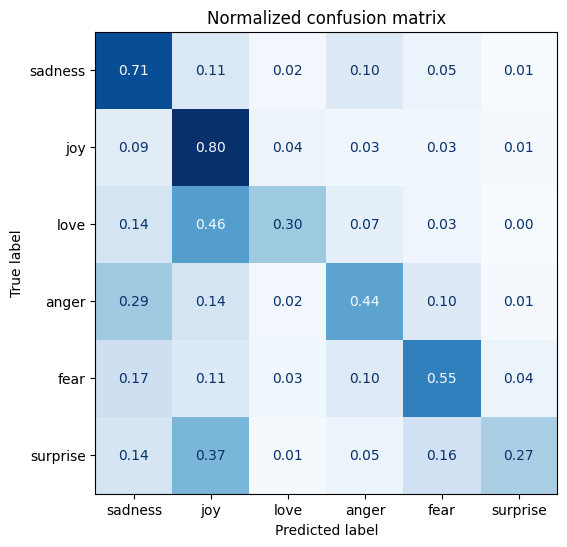

In [40]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid,labels)

In [ ]:
text = 'I love machine learning'
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)